In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [12]:
path='/Users/kanishkbhagat/DS/Datasets/Computer Vision/Multi Cancer New'
train,val=tf.keras.utils.image_dataset_from_directory(path,
                                                      batch_size=None,
                                                      image_size=(224,224),
                                                      seed=6,
                                                      validation_split=0.5,
                                                      subset='both',
                                                      label_mode='categorical')
                                                     
classes=train.class_names

Found 120002 files belonging to 24 classes.
Using 60001 files for training.
Using 60001 files for validation.


In [2]:
# path='/Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Multi Cancer/val'

# test=tf.keras.utils.image_dataset_from_directory(path,
#                                                       batch_size=None,
#                                                       image_size=(224,224),
#                                                       seed=6,
#                                                       label_mode='int')

In [3]:
x_test=[]
y_test=[]

for x,y in val.take(10):
    x_test.append(x)
    y_test.append(y.numpy())

In [14]:
rescale=tf.keras.layers.Rescaling(1./255)

train=train.map(lambda x,y:(rescale(x),y))
val=val.map(lambda x,y:(rescale(x),y))

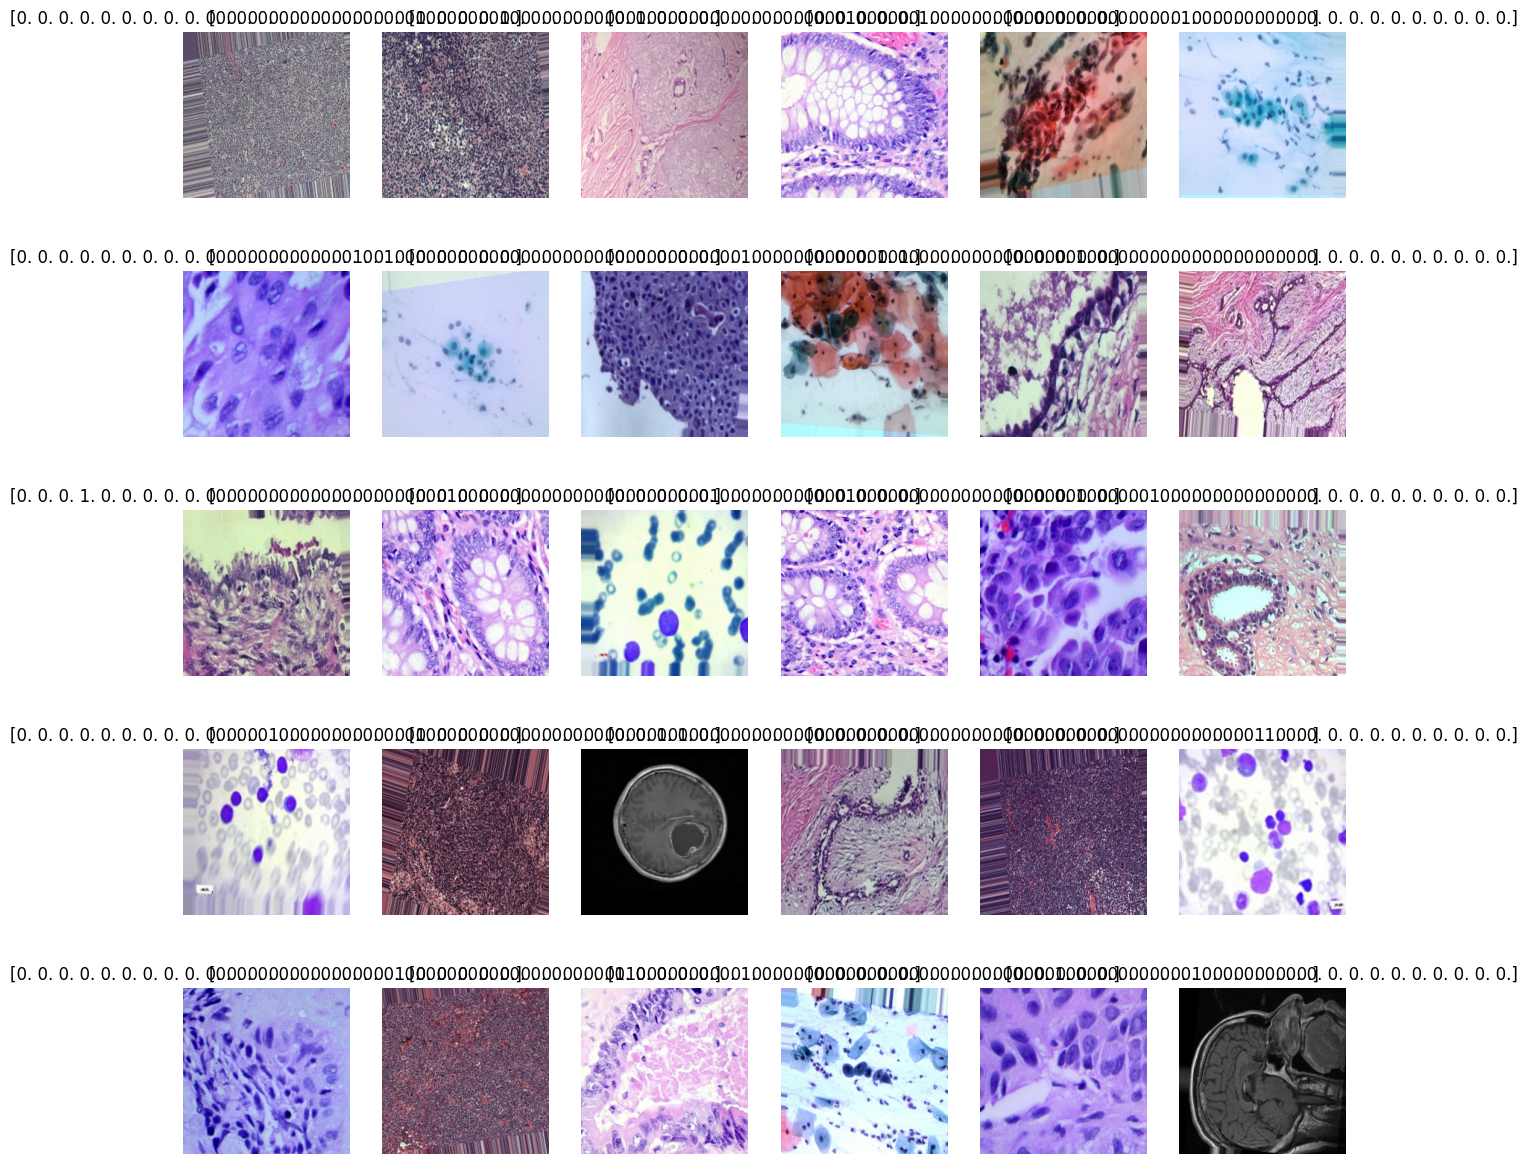

In [15]:
plt.figure(figsize=(15,15))
for i,(image,label) in enumerate(train.take(30)):
        plt.subplot(5,6,i+1)
        plt.imshow(image)
        plt.title(label.numpy())
        plt.axis('off')

In [6]:
def augment(image):
    image=tf.image.random_brightness(image,0.1)
    image=tf.image.random_contrast(image,0.1,0.3)
    image=tf.image.random_hue(image,0.1)
    image=tf.image.random_saturation(image,1,2.5)
    image=tf.image.random_flip_left_right(image)
    return image

In [7]:
train=train.map(lambda x,y:(x,to_categorical(y,num_classes=24)))
val=val.map(lambda x,y:(x,to_categorical(y,num_classes=24))).batch(64).prefetch(tf.data.AUTOTUNE)

In [8]:
train=train.map(lambda x,y:(augment(x),y)).batch(64).prefetch(tf.data.AUTOTUNE)

In [15]:
reg_l2=l2(0.001)


inputs = tf.keras.Input(shape=(224, 224, 3))

# Block 1
x = layers.Conv2D(64, (3, 3),strides=2, activation='relu', padding='same',kernel_regularizer=reg_l2)(inputs)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, (3, 3),strides=2, activation='relu', padding='same',kernel_regularizer=reg_l2)(x)
x = layers.BatchNormalization()(x)
x = layers. MaxPooling2D()(x)

x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same',kernel_regularizer=reg_l2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same',kernel_regularizer=reg_l2)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=reg_l2)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=reg_l2)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Dropout(0.4)(x)


x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(24, activation='softmax', name='predictions')(x)  # 1000 classes for ImageNet

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,155,160 (4.41 MB)

 Trainable params: 1,153,368 (4.40 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [9]:
resnet=tf.keras.applications. ResNet50(include_top=False,
                                      input_shape=(224,224,3))

resnet.trainable=False

inputs=layers.Input((224,224,3))
x=resnet(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
outputs=layers.Dense(24,activation='softmax')(x)

resnet_model=tf.keras.Model(inputs,outputs)
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │        49,176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,636,888 (90.17 MB)

 Trainable params: 49,176 (192.09 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

#model=tf.keras.models.load_model('/Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Multi Cancer/Model/multi_cancer-16-0.6168.keras')


In [17]:
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10,
                                                monitor='val_loss',
                                                restore_best_weights=True)

# reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                                                factor=0.5,
#                                                patience=7)

decay=ExponentialDecay(initial_learning_rate=0.0001,
                       decay_steps=5064,
                       decay_rate=0.5)

checkpoint=tf.keras.callbacks.ModelCheckpoint(f'/Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Multi Cancer/Model/resnet_multi_cancer1-{{epoch}}-{{val_loss:.4f}}.keras',
                                              monitor='val_loss',
                                              save_best_only=True,
                                              verbose=1)

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
              AUC()])

history=model.fit(train,
                  epochs=100,
                  validation_data=val,
                  callbacks=[early_stopping,checkpoint])

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7775 - auc_3: 0.9920 - loss: 1.0015
Epoch 1: val_loss improved from inf to 1.74640, saving model to /Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Multi Cancer/Model/resnet_multi_cancer1-1-1.7464.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 561s 596ms/step - accuracy: 0.7775 - auc_3: 0.9920 - loss: 1.0015 - val_accuracy: 0.5842 - val_auc_3: 0.9527 - val_loss: 1.7464
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7984 - auc_3: 0.9938 - loss: 0.9111
Epoch 2: val_loss did not improve from 1.74640
938/938 ━━━━━━━━━━━━━━━━━━━━ 562s 599ms/step - accuracy: 0.7985 - auc_3: 0.9938 - loss: 0.9111 - val_accuracy: 0.5657 - val_auc_3: 0.9407 - val_loss: 1.9903
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8206 - auc_3: 0.9947 - loss: 0.8342
Epoch 3: val_loss did not improve from 1.74640
938/938 ━━━━━━━━━━━━━━━━━━━━ 548s 584ms/step - accuracy: 0.8206 - auc_3: 0.9947 - loss: 0.8342 - val_

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9650 - auc_3: 0.9996 - loss: 0.2196
Epoch 41: val_loss did not improve from 0.58610
938/938 ━━━━━━━━━━━━━━━━━━━━ 360s 383ms/step - accuracy: 0.9650 - auc_3: 0.9996 - loss: 0.2196 - val_accuracy: 0.8630 - val_auc_3: 0.9864 - val_loss: 0.6110
Epoch 42/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9681 - auc_3: 0.9996 - loss: 0.2109
Epoch 42: val_loss improved from 0.58610 to 0.40742, saving model to /Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Multi Cancer/Model/resnet_multi_cancer1-42-0.4074.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 358s 382ms/step - accuracy: 0.9681 - auc_3: 0.9996 - loss: 0.2109 - val_accuracy: 0.9040 - val_auc_3: 0.9947 - val_loss: 0.4074
Epoch 43/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9693 - auc_3: 0.9996 - loss: 0.2082
Epoch 43: val_loss did not improve from 0.40742
938/938 ━━━━━━━━━━━━━━━━━━━━ 359s 383ms/step - accuracy: 0.9693 - auc_3: 0.9996 - loss: 0.2082 - val_ac

In [18]:
plt.figure(figsize=(5,3))

plt.plot(history.history['accuracy'],marker='.')
plt.plot(history.history['val_accuracy'],marker='.')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.grid()
plt.show()


In [19]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'],marker='.')
plt.plot(history.history['val_loss'],marker='.')
plt.title('Error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.grid()
plt.show()

In [56]:
# encoder=LabelEncoder()

# classes=encoder.fit_transform(classes)

In [9]:
# y_scores = model.predict(x_test)


# classes = [
#     'brain_glioma', 'brain_menin', 'brain_tumor', 'breast_benign', 'breast_malignant',
#     'cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi',
#     'colon_aca', 'colon_bnt', 'leukemia_benign', 'leukemia_early', 'leukemia_pre',
#     'leukemia_pro', 'lung_aca', 'lung_bnt', 'lung_scc', 'lymph_cll',
#     'lymph_fl', 'lymph_mcl', 'oral_normal', 'oral_scc'
# ]

# # Binarize the output
# y_true_binary = label_binarize(y_test, classes=list(range(len(classes))))

# # Plot ROC curve for each class
# plt.figure(figsize=(12, 8))

# for i in range(len(classes)):
#     fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_scores[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (area = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC for Multi-Class')
# plt.legend(loc="lower right", fontsize='small', ncol=2)
# plt.show()


In [9]:
cancer_model=tf.keras.models.load_model('/Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Multi Cancer/Model/resnet_multi_cancer1-42-0.4074.keras')
cancer_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
              AUC()])

In [10]:
cancer_model.evaluate(val)

108/938 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - accuracy: 0.9011 - auc: 0.9939 - loss: 0.4214

KeyboardInterrupt: 

In [11]:
def predict(image):
    
    image=np.array(image)
    
    plt.imshow(image/255)
    plt.axis('off')
    
    image=np.expand_dims(image,axis=0)
    pred=cancer_model.predict(image)
    pred=np.argmax(pred,axis=1)[0]
    
    plt.title(f'Pred : {classes[pred]}')

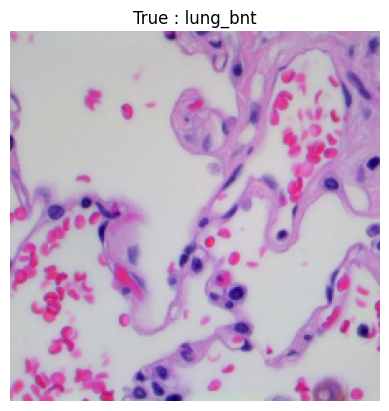

In [12]:
plt.imshow(x_test[0]/255)
plt.title(f'True : {classes[y_test[0]]}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


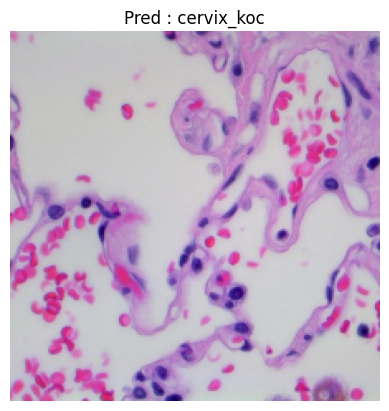

In [13]:
predict(x_test[0])